In [47]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import auc as calc_auc

In [48]:
df = pd.read_csv('/ibex/project/c2205/jiayi/Kp_ml/gffs/results/gene_presence_absence_roary.csv')
genome_data = df.iloc[:, 14:]  # All genome columns
genes = df['Gene']             # Gene names

#Convert to long format and then pivot to binary presence/absence
binary_matrix = genome_data.notnull().astype(int)
binary_matrix.insert(0, 'Gene', genes)
binary_matrix = binary_matrix.set_index('Gene').T

In [53]:
#genome with metadata
metadata = pd.read_csv('/ibex/project/c2205/jiayi/Kp_ml/Kp_clincal_metadata_18May.tsv', sep='\t')
meta_df = metadata[['strain', 'Age', 'Gender', 'LOS', 'Culture_type_Ass', 'Patient_Status']]
meta_df = meta_df.set_index('strain')

gender_map = {'F': 0, 'M': 1}
meta_df['Gender'] = meta_df['Gender'].map(gender_map)
status_map = {'Alive': 0, 'Died': 1}
meta_df['Death'] = meta_df['Patient_Status'].map(status_map)

meta_df = pd.get_dummies(meta_df, columns=['Culture_type_Ass'], prefix='', prefix_sep='')

meta_df = meta_df.dropna(subset=['Age','Gender','LOS','Blood','Urine','Respiratory','Others','Death'])
meta_df[['Blood','Urine','Respiratory','Others']] = meta_df[['Blood','Urine','Respiratory','Others']].astype(int)
meta_df['Gender'] = meta_df['Gender'].astype(int)
meta_df['Death'] = meta_df['Death'].astype(int)

merged_df = binary_matrix.merge(meta_df, left_index=True, right_index=True)
merged_df.to_csv("/ibex/project/c2205/jiayi/Kp_ml/ml_model/LG_ready_dataset.csv")

In [49]:
#only genome
metadata = pd.read_csv('/ibex/project/c2205/jiayi/Kp_ml/Kp_clincal_metadata_18May.tsv', sep='\t')
meta_df = metadata[['strain', 'Age', 'Gender', 'LOS', 'Culture_type_Ass', 'Patient_Status']]
meta_df = meta_df.dropna(subset=['Age', 'Gender', 'LOS', 'Culture_type_Ass', 'Patient_Status'])
meta_df = meta_df[meta_df['Patient_Status'] != 'NF']
meta_df = meta_df[['strain', 'Patient_Status']]
meta_df = meta_df.set_index('strain')

status_map = {'Alive': 0, 'Died': 1}
meta_df['Death'] = meta_df['Patient_Status'].map(status_map)
meta_df['Death'] = meta_df['Death'].astype(int)

merged_df = binary_matrix.merge(meta_df, left_index=True, right_index=True)

In [54]:
# Separate features and target, Split the data into training and testing sets
X = merged_df.drop(columns=['Patient_Status','Death'])  # features
y = merged_df['Death']                 #label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [55]:
logreg = LogisticRegression(solver='liblinear')  # solver must support your chosen penalty

# Define parameter grid
param_grid = {
    'max_iter': [100, 200, 500, 1000, 5000],
    'penalty': ['l2']
}

# Grid search setup
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_

# Predict & evaluate
y_pred = best_model.predict(X_test)

# Absolute coefficients as importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(best_model.coef_[0])
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.reset_index(drop=True, inplace=True)
print(importance_df.head(10))

#ROC curve data
y_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_df = pd.DataFrame({
    'false_positive_rate': fpr,
    'true_positive_rate': tpr,
    'threshold': thresholds
})

#roc_df.to_csv('/ibex/project/c2205/jiayi/Kp_ml/ml_model/LG_roc_curve_data.csv', index=False)

# calculate AUC
auc = roc_auc_score(y_test, y_probs)
print(f"AUC: {auc}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
                  Feature  Importance
0               group_959    1.246545
1                  pgrR_1    1.174349
2               group_209    1.164169
3              group_1022    1.021155
4                    galD    0.881941
5              group_1018    0.847509
6                 group_6    0.842447
7              group_1177    0.839927
8               group_715    0.802584
9  moxC~~~moxC_2~~~moxC_1    0.786423
AUC: 0.771987202275151


Test AUC = 0.773
95% CI = [0.715, 0.829]


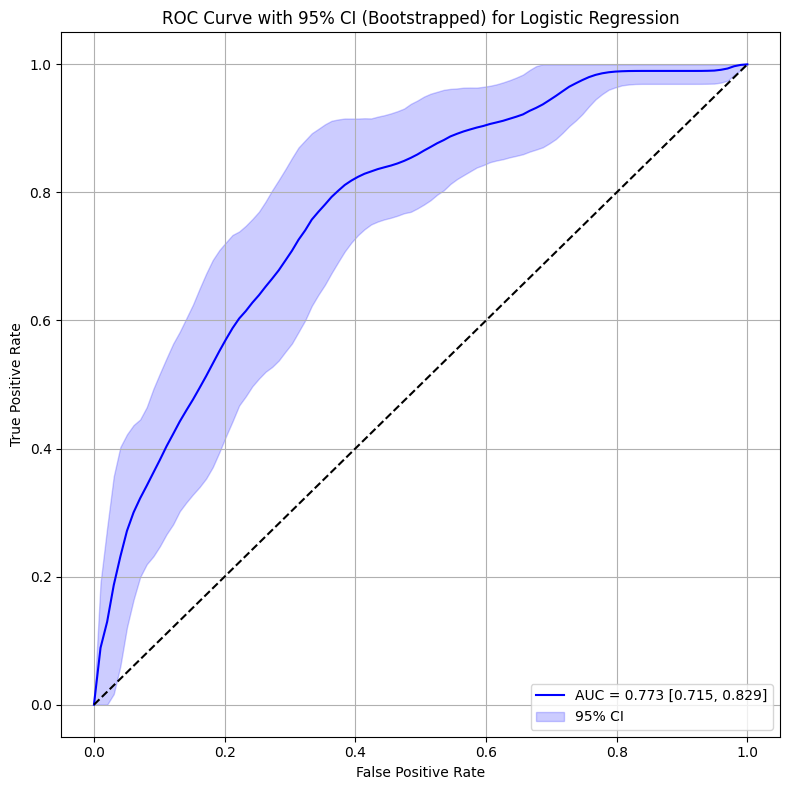

In [56]:
# Bootstrapping for ROC curve with 95% CI
n_bootstraps = 1000
rng_seed = 42  # for reproducibility
rng = np.random.RandomState(rng_seed)

bootstrapped_tprs = []
bootstrapped_aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement
    indices = rng.randint(0, len(y_probs), len(y_probs))
    if len(np.unique(y_test.iloc[indices])) < 2:
        continue  # skip if only one class is present

    fpr, tpr, _ = roc_curve(y_test.iloc[indices], y_probs[indices])
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    bootstrapped_tprs.append(tpr_interp)
    score = roc_auc_score(y_test.iloc[indices], y_probs[indices])
    bootstrapped_aucs.append(score)

# Compute stats
bootstrapped_tprs = np.array(bootstrapped_tprs)
mean_tpr = np.mean(bootstrapped_tprs, axis=0)
std_tpr = np.std(bootstrapped_tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)

# Print AUC statistics
bootstrapped_aucs = np.array(bootstrapped_aucs)
auc_mean = np.mean(bootstrapped_aucs)
auc_ci_lower = np.percentile(bootstrapped_aucs, 2.5)
auc_ci_upper = np.percentile(bootstrapped_aucs, 97.5)

print(f"Test AUC = {auc_mean:.3f}")
print(f"95% CI = [{auc_ci_lower:.3f}, {auc_ci_upper:.3f}]")

# Plot
plt.figure(figsize=(8, 8))
plt.plot(mean_fpr, mean_tpr, label=f"AUC = {auc_mean:.3f} [{auc_ci_lower:.3f}, {auc_ci_upper:.3f}]", color='blue')
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='blue', alpha=0.2, label="95% CI")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with 95% CI (Bootstrapped) for Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#save in csv
roc_ci_df = pd.DataFrame({
    'fpr': mean_fpr,
    'mean_tpr': mean_tpr,
    'tpr_lower': tpr_lower,
    'tpr_upper': tpr_upper
})
roc_ci_df.to_csv('/ibex/project/c2205/jiayi/Kp_ml/ml_model/LG_roc_curve_data_only_genome.csv', index=False)

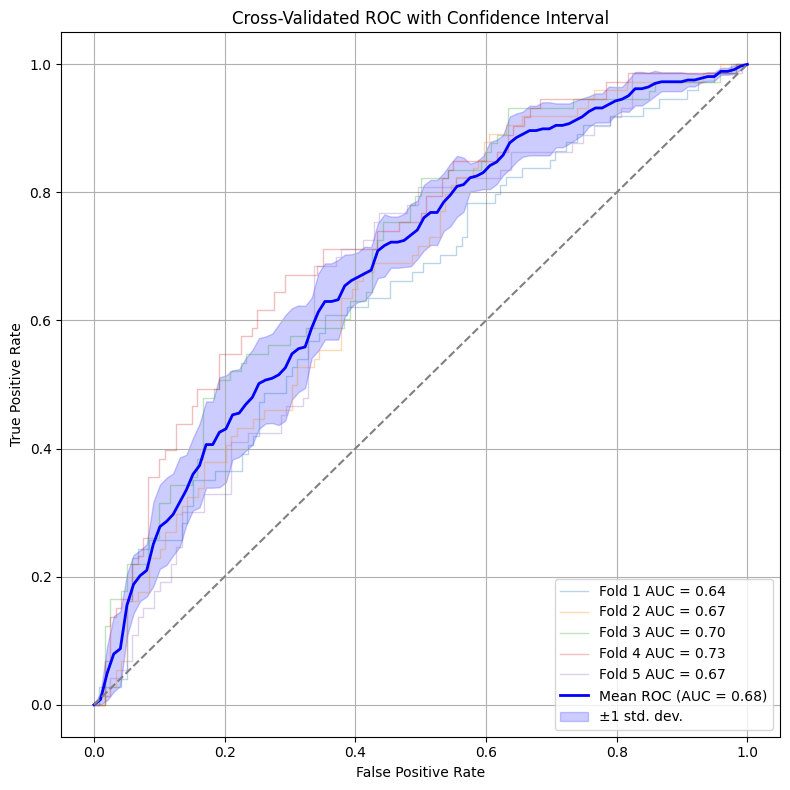

In [ ]:
#training ROC curve with confidence intervals
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

plt.figure(figsize=(8, 8))

for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_cv_train, X_cv_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_cv_train, y_cv_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = best_model.fit(X_cv_train, y_cv_train)
    y_cv_probs = model.predict_proba(X_cv_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_cv_test, y_cv_probs)

    # Compute and store AUC
    auc_val = calc_auc(fpr, tpr)
    aucs.append(auc_val)

    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    # Plot each fold's ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f"Fold {i+1} AUC = {auc_val:.2f}")

# Mean ROC + CI
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = calc_auc(mean_fpr, mean_tpr)

tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC (AUC = {mean_auc:.2f})", lw=2)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='blue', alpha=0.2, label='±1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("Cross-Validated ROC with Confidence Interval")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
importance_df.to_csv("/ibex/project/c2205/jiayi/Kp_ml/ml_model/LG_feature_importance.csv", index=False)

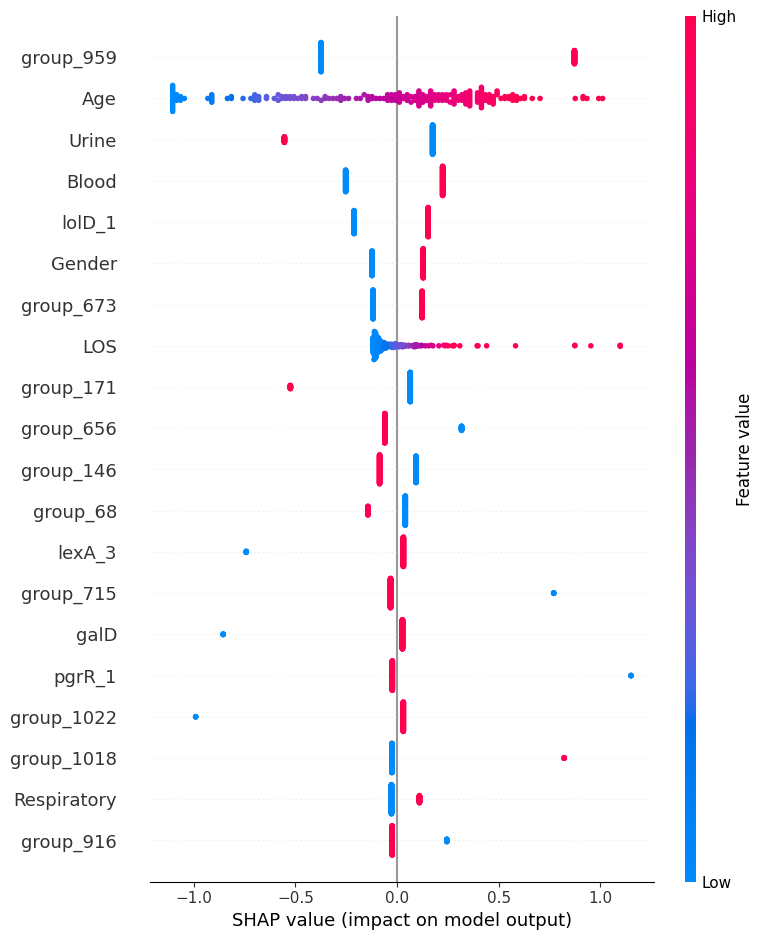

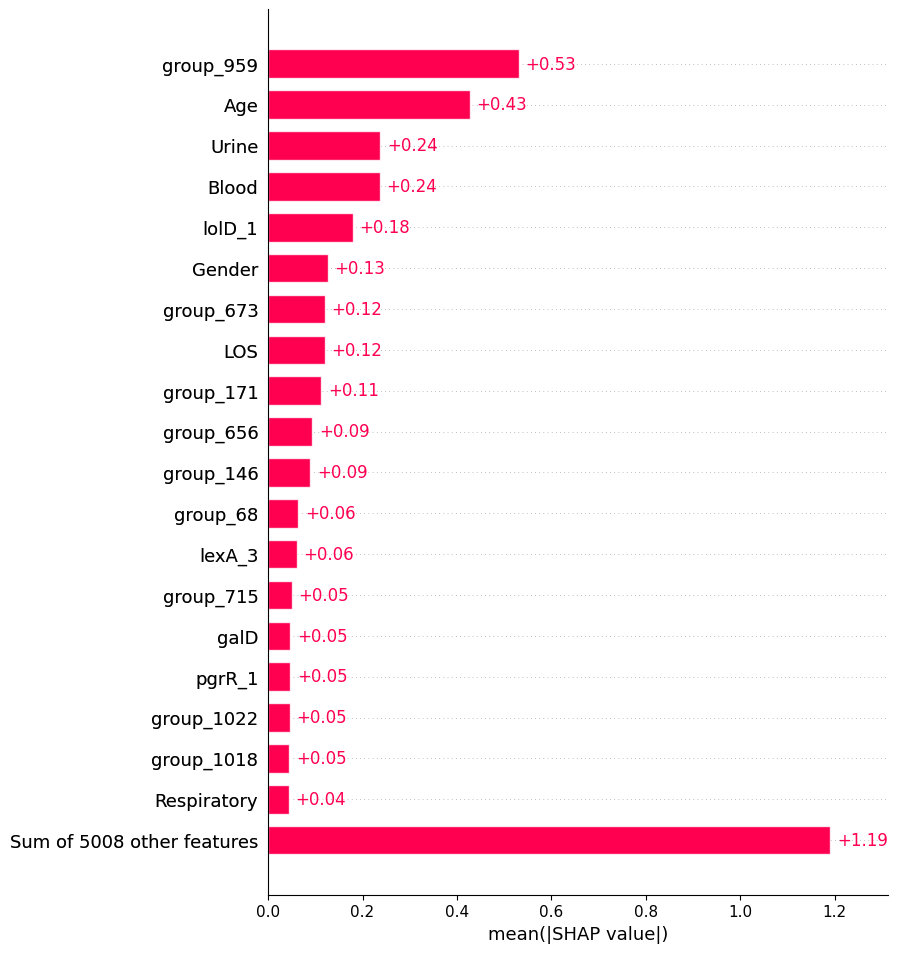

'\nshap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)\nfeature_values_df = pd.DataFrame(shap_values.data, columns=X_test.columns)\n\n# Melt to long format\nshap_long = shap_values_df.melt(var_name=\'feature\', value_name=\'shap_value\')\nfeature_long = feature_values_df.melt(var_name=\'feature\', value_name=\'feature_value\')\n\n# Combine both\nshap_long[\'feature_value\'] = feature_long[\'feature_value\']\n\n# Save to CSV\nshap_long.to_csv("/ibex/project/c2205/jiayi/Kp_ml/ml_model/shap_detailed_plot.csv", index=False)\n\n# Compute mean absolute SHAP values\nmean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=False)\n\n# Select top 20 features\ntop_20_features = mean_abs_shap.head(20).index.tolist()\n\n# Filter SHAP and feature values for top 20 features\nshap_long_top20 = shap_long[shap_long[\'feature\'].isin(top_20_features)]\n\n# Save to CSV\nshap_long_top20.to_csv("/ibex/project/c2205/jiayi/Kp_ml/ml_model/shap_detailed_top20_plot.csv", index=Fal

In [7]:
explainer = shap.Explainer(best_model, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_test)

shap.plots.bar(shap_values, max_display=20)

'''
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
feature_values_df = pd.DataFrame(shap_values.data, columns=X_test.columns)

# Melt to long format
shap_long = shap_values_df.melt(var_name='feature', value_name='shap_value')
feature_long = feature_values_df.melt(var_name='feature', value_name='feature_value')

# Combine both
shap_long['feature_value'] = feature_long['feature_value']

# Save to CSV
shap_long.to_csv("/ibex/project/c2205/jiayi/Kp_ml/ml_model/shap_detailed_plot.csv", index=False)

# Compute mean absolute SHAP values
mean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=False)

# Select top 20 features
top_20_features = mean_abs_shap.head(20).index.tolist()

# Filter SHAP and feature values for top 20 features
shap_long_top20 = shap_long[shap_long['feature'].isin(top_20_features)]

# Save to CSV
shap_long_top20.to_csv("/ibex/project/c2205/jiayi/Kp_ml/ml_model/shap_detailed_top20_plot.csv", index=False)
'''

In [7]:
# Evaluate the model
print("Best parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Convert CV results to DataFrame
cv_results_df = pd.DataFrame(grid.cv_results_)

# Save selected columns to TSV
cv_results_df.to_csv("/ibex/project/c2205/jiayi/Kp_ml/ml_model/logreg_gridsearch_results.tsv", sep="\t", index=False)

with open("/ibex/project/c2205/jiayi/Kp_ml/ml_model/model_metrics.txt", "w") as f:
    f.write("Best parameters:" + str(grid.best_params_) + "\n")
    f.write("=== Model Evaluation Metrics ===\n")
    f.write("Accuracy: " + str(accuracy_score(y_test, y_pred)) + "\n")
    f.write("F1 score: " + str(f1_score(y_test, y_pred)) + "\n")
    f.write("=== Classification Report ===\n")
    f.write(str(classification_report(y_test, y_pred)) + "\n")
    f.write("=== Confusion Matrix ===\n")
    f.write(str(confusion_matrix(y_test, y_pred)) + "\n")


Best parameters: {'max_iter': 100, 'penalty': 'l2'}
Accuracy: 0.6859504132231405
Confusion Matrix:
 [[119  26]
 [ 50  47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.82      0.76       145
           1       0.64      0.48      0.55        97

    accuracy                           0.69       242
   macro avg       0.67      0.65      0.66       242
weighted avg       0.68      0.69      0.68       242

